# Estimating KL divergences from samples using deep learning
**References:**

`Sebastian Nowozin, Botond Cseke, Ryota Tomioka, f-GAN: Training Generative Neural Samplers using Variational Divergence Minimization, 2016.`


`X. Nguyen, M. J. Wainwright, and M. I. Jordan. Estimating divergence functionals and the likelihood ratio
by convex risk minimization. Information Theory, IEEE, 56(11):5847–5861, 2010`

### Overview
The goal is to estimate a lower bound to the KL divergence using samples from two distributions. The following description follows Nowozin et al., which neatly describes work by Nguyen et al. to generalize GANs.

General class of f-divergences:
$$ D_f (P || Q) = \int_{\mathcal{X}} q(x) f\frac{p(x)}{q(x)} dx $$

With $f(u)=u\log(u)$, $D_f (P || Q)$ reduced to the KL-divergence.

Nguyen  showed, using a generalization of a Legendre transform of $f(u)$, defined as $f^*$, that

$$ D_f (P || Q) \geq  \sup_{T \in \mathcal{T}} E_{x \sim P}[T(x)] - E_{x \sim Q} [f^*\left( T(x) \right )] $$

where $\mathcal{T}$ is some class of functions, like neural nets and $ T:\mathcal{X} \rightarrow \mathbb{R} $. It can be shown (I don't know how) that the lower bound is maximized for T^*(x):
$$ T^*(x) = f'\left(\frac{p(x)}{q(x)} \right)$$

### Likelihood ratio estimation and the KL divergence
For the KL divergence, 
$$f^*(t) = \exp(t - 1) $$
and 
$$ T^*(x) = 1 + \log\frac{p(x)}{q(x)} $$ 
Let $r(x) = \frac{p(x)}{q(x)}$, then
$$ D_{KL} (P || Q) \geq  1 + E_{x \sim P}[\log r(x)] - E_{x \sim Q} [r(x)] $$

So the game is to parameterize r(x) by a neural net and maximize the above lower bound.


### In practice
Don't bother with the likelihood ratio estimation and do as Nowozin et al suggest. Maximize
$$ F(\omega) = E_{x \sim P}[V_\omega(x)] - E_{x \sim Q} [\exp(V_\omega(x) - 1) ]$$

where $V_\omega(x):\mathcal{X} \rightarrow \mathbb{R}$ (positive and negative real number) and is a neural net parametrized by $\omega$. Nowozin et al. approximate the expectations using minibatch samples.



In [1]:
import numpy as onp
from scipy.stats import norm
import jax.numpy as np


from matplotlib import pylab as plt
%matplotlib inline

import sys
sys.path.append('../')
from kl_lower_bounds import kl_lower_bounds as klb

# Example: estimating the KL divergence between 1D Gaussians from samples

## Establishing the distrubtions and samples

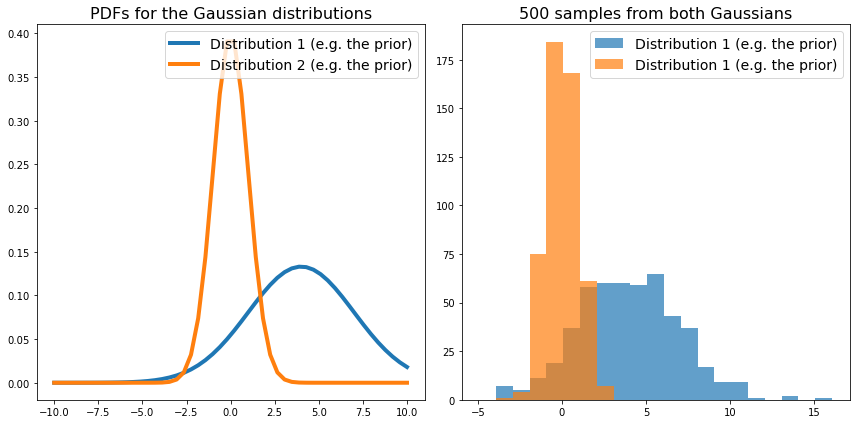

In [2]:
# The parameters of the 1st Gaussian (e.g. the prior)
mu1 = 4
sigma1 = 3
p1 = norm(loc=mu1, scale=sigma1)

# The parameters of the 2nd Gaussian (e.g. the posterior)
mu2 = 0
sigma2 = 1
p2 = norm(loc=mu2, scale=sigma2)

# The target for estimation, the actual KL divergence between p1 and p2.
# This direction is useful for computing an upper bound to the log marginal likelihood
true_kl = klb.kl_normal(mu2, sigma2, mu1, sigma1 )


# Fix the random seed
rs = onp.random.RandomState(seed=12345)
p1.random_state = rs
p2.random_state = rs

fig, ax = plt.subplots(1,2, figsize=(12,6))

x = onp.linspace(-10,10)
ax[0].plot(x, p1.pdf(x), label='Distribution 1 (e.g. the prior)', lw=4)
ax[0].plot(x, p2.pdf(x), label='Distribution 2 (e.g. the prior)', lw=4)
ax[0].legend(fontsize=14, loc=1)
ax[0].set_title('PDFs for the Gaussian distributions', fontsize=16)

# Now drawing the samples from which the KL divergence will be estimated.
nsamps = 500
prior_samps = np.array(p1.rvs(nsamps)).reshape((nsamps, 1))
post_samps = np.array(p2.rvs(nsamps)).reshape((nsamps, 1))


bottom = float(np.min(np.hstack((post_samps, prior_samps))))
top = float(np.max(np.hstack((post_samps, prior_samps))))
bins = np.arange(bottom -1, top + 1, 1)

ax[1].hist(prior_samps.flatten(), alpha=0.7, bins=bins, label='Distribution 1 (e.g. the prior)')
ax[1].hist(post_samps.flatten(), alpha=0.7, bins=bins, label='Distribution 1 (e.g. the prior)')
ax[1].legend(fontsize=14, loc=1)
ax[1].set_title('{0} samples from both Gaussians'.format(nsamps), fontsize=16)

plt.tight_layout()
plt.show()

## Using a neural net to estimate a lower bound to the KL divergence using the samples
The NN is optimized using adam.

In [3]:
from time import time

In [4]:
# NN parameters
nsteps = 300  # The maximum number of NN steps
batch_size = 30 # The size of the minibatch samples
save_freq = 5  # Only save the estimate every 5 steps 

# The NN has 3 hidden layers, each with 100 neurons.
layer_shapes = (1, 100, 100, 100, 1)
# Draw the initial parameters from a Gaussian, with a standard deviation of 0.1 and a fixed random seed.
params = klb.init_nn_params(layer_shapes, 0.1, 3)

# Run the optimization:
t0 = time()
lb, final_params = klb.get_kl_lower_bound(params, prior_samps, post_samps, batch_size=batch_size, nsteps=nsteps,record_freq=save_freq)
print('Time elapsed =',time()-t0, 'seconds.')

Time elapsed = 1.8514111042022705 seconds.


**Now plot!**

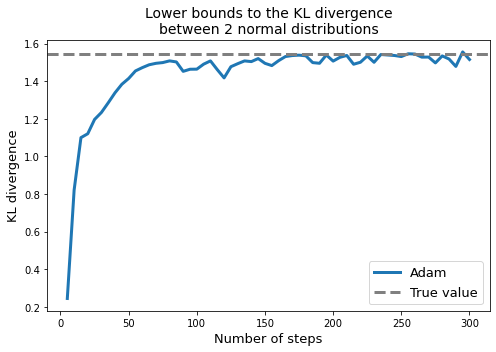

In [5]:
fig, ax = plt.subplots(1, figsize=(7,5))

t = np.arange(5, nsteps + 1, save_freq)
ax.plot(t, lb, lw=3, label='Adam')

ax.axhline(true_kl, color='grey', ls='--', lw=3, label='True value')
ax.legend(fontsize=13)

ax.set_title('Lower bounds to the KL divergence\nbetween 2 normal distributions', fontsize=14)
ax.set_xlabel('Number of steps', fontsize=13)
ax.set_ylabel('KL divergence', fontsize=13)

plt.tight_layout()
plt.show()

How does this compare to vanilla stochastic gradient decent?

Time elapsed = 1.2778139114379883 seconds.


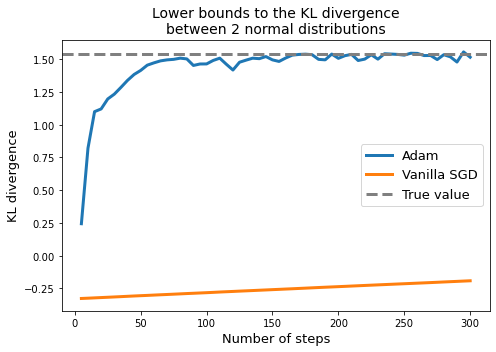

In [6]:
# Run the optimization:
t0 = time()
lb_sgd, final_params = klb.get_kl_lower_bound_sgd(params, prior_samps, post_samps, batch_size=batch_size, nsteps=nsteps,record_freq=save_freq)
print('Time elapsed =',time()-t0, 'seconds.')

fig, ax = plt.subplots(1, figsize=(7,5))

t = np.arange(5, nsteps + 1, save_freq)
ax.plot(t, lb, lw=3, label='Adam')
ax.plot(t, lb_sgd, lw=3, label='Vanilla SGD')

ax.axhline(true_kl, color='grey', ls='--', lw=3, label='True value')
ax.legend(fontsize=13)

ax.set_title('Lower bounds to the KL divergence\nbetween 2 normal distributions', fontsize=14)
ax.set_xlabel('Number of steps', fontsize=13)
ax.set_ylabel('KL divergence', fontsize=13)

plt.tight_layout()
plt.show()

Optimization with adam is vastly superior to the most basic stochastic gradient decent algorithm.